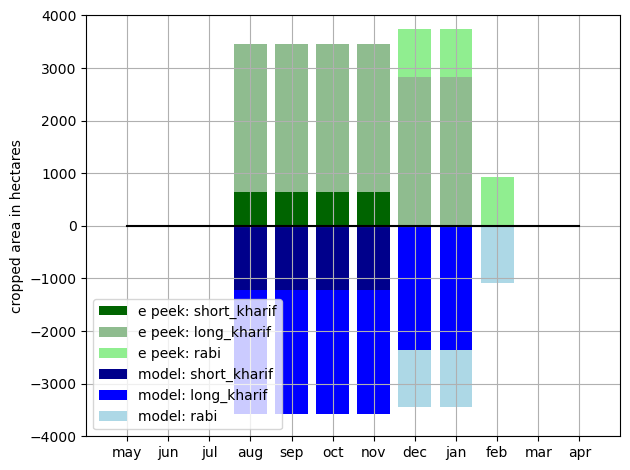

In [1]:
import argparse
import copy
import json
import math
import os
import pathlib
import time
import psycopg2
import requests
from requests.adapters import HTTPAdapter
from requests.auth import HTTPBasicAuth
from urllib3.util.retry import Retry
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import rasterio
from shapely.wkt import loads
from rasterio.mask import mask
import cv2

from PIL import Image
import pandas as pd

from config.config import Config
from utils.postgres_utils import *
from utils.raster_utils import *

config = Config()
pgconn_obj = PGConn(config)
pgconn=pgconn_obj.connection()

months_map = {
    'may': 0,
    'jun': 1,
    'jul': 2,
    'aug': 3,
    'sep': 4,
    'oct': 5,
    'nov': 6,
    'dec': 7,
    'jan': 8,
    'feb': 9,
    'mar': 10,
    'apr': 11
}
months = [
    'may',
    'jun',
    'jul',
    'aug',
    'sep',
    'oct',
    'nov',
    'dec',
    'jan',
    'feb',
    'mar',
    'apr'
]
e_peek_green_area = {
    'long_kharif': np.zeros(12),
    'short_kharif': np.zeros(12),
    'rabi': np.zeros(12)
}
model_green_area = {
    'long_kharif': np.zeros(12),
    'short_kharif': np.zeros(12),
    'rabi': np.zeros(12)
}

months_data = ['01','02','03','04','05','06',
                '07','08','09','10','11','12']
months_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
study_months = config.setup_details["months"]["agricultural_months"]
columns = ""
for month in study_months:
    columns += f"{months_names[month[1]]}_{month[0]}_crop_presence::int,"

sql_query = """
select
    array_agg(crop_name),
    st_area(farm_geom)/10000 as area
from
    nearest_farmplots_map
join
    filtered_amravati_pahani
using (
    khate_number,
    full_name,
    total_holding_area
)
where
    sowing_season_code in (1,2)
group by
    farm_geom
"""
with pgconn.cursor() as curs:
    curs.execute(sql_query)
    rows = curs.fetchall()

toor_area = np.sum([row[1] for row in rows if 'तुर' in row[0]])
only_cotton_area = np.sum([row[1] for row in rows if 'कापुस' in row[0]])
soybean_area = np.sum([row[1] for row in rows if ('सोयाबीन' in row[0] and 'तुर' not in row[0] and 'कापुस' not in row[0])])

lk_area = toor_area + 0.9*only_cotton_area
sk_area = soybean_area + 0.1*only_cotton_area
r_area = np.sum([row[1] for row in rows if 'हरभरा' in row[0]])

e_peek_green_area['long_kharif'][months_map['aug']] += lk_area
e_peek_green_area['long_kharif'][months_map['sep']] += lk_area
e_peek_green_area['long_kharif'][months_map['oct']] += lk_area
e_peek_green_area['long_kharif'][months_map['nov']] += lk_area
e_peek_green_area['long_kharif'][months_map['dec']] += lk_area
e_peek_green_area['long_kharif'][months_map['jan']] += lk_area

e_peek_green_area['rabi'][months_map['dec']] += r_area
e_peek_green_area['rabi'][months_map['jan']] += r_area
e_peek_green_area['rabi'][months_map['feb']] += r_area

e_peek_green_area['short_kharif'][months_map['aug']] += sk_area
e_peek_green_area['short_kharif'][months_map['sep']] += sk_area
e_peek_green_area['short_kharif'][months_map['oct']] += sk_area
e_peek_green_area['short_kharif'][months_map['nov']] += sk_area

sql_query = f"""
select
    crop_cycle_22_23,
    khate_number,
    full_name,
    total_holding_area,
    key,
    st_astext(st_transform(farm_geom, 3857)),
    {columns}
    st_area(farm_geom)/10000,
    count(*)
from
    nearest_farmplots_map
join
    filtered_amravati_pahani
using (
    khate_number,
    full_name,
    total_holding_area
)
group by
    khate_number,
    full_name,
    total_holding_area,
    key,
    farm_geom,
    {columns}
    crop_cycle_22_23
"""
with pgconn.cursor() as curs:
    curs.execute(sql_query)
    rows = curs.fetchall()
model_sk = 0
model_lk = 0
model_r = 0
for row in rows:
    probs = row[6:-2]
    area = row[-2]
    label = row[0]
    if label == 'short_kharif':
        model_sk += area
    elif label == 'long_kharif':
        model_lk += area
    elif label == 'kharif_and_rabi':
        model_r += area
        model_sk += area

model_green_area['long_kharif'][months_map['aug']] += model_lk
model_green_area['long_kharif'][months_map['sep']] += model_lk
model_green_area['long_kharif'][months_map['oct']] += model_lk
model_green_area['long_kharif'][months_map['nov']] += model_lk
model_green_area['long_kharif'][months_map['dec']] += model_lk
model_green_area['long_kharif'][months_map['jan']] += model_lk

model_green_area['rabi'][months_map['jan']] += model_r
model_green_area['rabi'][months_map['feb']] += model_r
model_green_area['rabi'][months_map['dec']] += model_r

model_green_area['short_kharif'][months_map['aug']] += model_sk
model_green_area['short_kharif'][months_map['sep']] += model_sk
model_green_area['short_kharif'][months_map['oct']] += model_sk
model_green_area['short_kharif'][months_map['nov']] += model_sk

fig, ax = plt.subplots()
plt.grid()

ax.bar(months, e_peek_green_area['short_kharif'], label='e peek: short_kharif', color='darkgreen')
ax.bar(months, e_peek_green_area['long_kharif'], bottom=e_peek_green_area['short_kharif'], label='e peek: long_kharif', color='darkseagreen')
current = [sum(x) for x in zip(e_peek_green_area['short_kharif'], e_peek_green_area['long_kharif'])]
ax.bar(months, e_peek_green_area['rabi'], bottom=current, label='e peek: rabi', color='lightgreen')

ax.bar(months, -model_green_area['short_kharif'], label='model: short_kharif', color='darkblue')
ax.bar(months, -model_green_area['long_kharif'], bottom=-model_green_area['short_kharif'], label='model: long_kharif', color='blue')
current = [sum(x) for x in zip(-model_green_area['short_kharif'], -model_green_area['long_kharif'])]
ax.bar(months, -model_green_area['rabi'], bottom=current, label='model: rabi', color='lightblue')

plt.plot([0 for _ in months], color = 'black')
plt.ylabel('cropped area in hectares')
ax.set_ylim([-4000, 4000])
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [2]:
sk = []
for i in range(9):
    probs = np.zeros(12)
    probs[i] = 1
    probs[(i+1)%12] = 1
    probs[(i+2)%12] = 1
    probs[(i+3)%12] = 1
    sk.append(probs)
for i in range(10):
    probs = np.zeros(12)
    probs[i] = 1
    probs[(i+1)%12] = 1
    probs[(i+2)%12] = 1
    sk.append(probs)
print(sk)

lk = []
for i in range(7):
    probs = np.zeros(12)
    probs[i] = 1
    probs[(i+1)%12] = 1
    probs[(i+2)%12] = 1
    probs[(i+3)%12] = 1
    probs[(i+4)%12] = 1
    probs[(i+5)%12] = 1
    lk.append(probs)
for i in range(8):
    probs = np.zeros(12)
    probs[i] = 1
    probs[(i+1)%12] = 1
    probs[(i+2)%12] = 1
    probs[(i+3)%12] = 1
    probs[(i+4)%12] = 1
    lk.append(probs)
print(lk)

kr = []
for i in range(5):
    probs = np.zeros(12)
    probs[i] = 1
    probs[(i+1)%12] = 1
    probs[(i+2)%12] = 1
    probs[(i+3)%12] = 1
    probs[(i+5)%12] = 1
    probs[(i+6)%12] = 1
    probs[(i+7)%12] = 1
    kr.append(probs)
for i in range(6):
    probs = np.zeros(12)
    probs[i] = 1
    probs[(i+1)%12] = 1
    probs[(i+2)%12] = 1
    probs[(i+4)%12] = 1
    probs[(i+5)%12] = 1
    probs[(i+6)%12] = 1
    kr.append(probs)
print(kr)

p = [np.ones(12)]
print(p)

with open('new_cycle_annotations.csv', 'w') as file:
    for probs in sk:
        for prob in probs:
            file.write(str(prob) + ',')
        file.write('short_kharif\n')
    for probs in lk:
        for prob in probs:
            file.write(str(prob) + ',')
        file.write('long_kharif\n')
    for probs in kr:
        for prob in probs:
            file.write(str(prob) + ',')
        file.write('kharif_and_rabi\n')
    for probs in p:
        for prob in probs:
            file.write(str(prob) + ',')
        file.write('perennial\n')

[array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.]), array([0., 0., 0., 0., 0., 0.,

321.30369999999994


/tmp/ipykernel_6602/3523952051.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et0['et0'][i] *= 0
/tmp/ipykernel_6602/3523952051.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et0['et0'][i] *= 0
/tmp/ipykernel_6602/3523952051.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et0['et0'][i] *= 0
/tmp/ipykernel_6602/3523952051.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



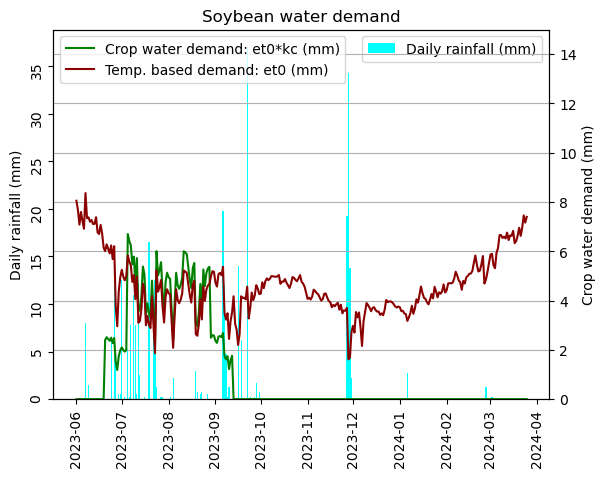

In [3]:
fig, ax1 = plt.subplots()
rain = pd.read_csv('~/rain_low.csv')
et0 = pd.read_csv('~/et0_low.csv')
rain['date'] = pd.to_datetime(rain['date'])
et0['date'] = pd.to_datetime(et0['date'])
og_et0 = copy.deepcopy(et0['et0'])

#plt.plot([item for item in et0['date']], [item for item in et0['et0']])
# soybean

kc_init = 0.4
kc_mid = 1.15
kc_end = 0.5
sowing_dt = datetime(2023, 6, 20)
for (i,dt) in enumerate(et0['date']):
    if dt >= sowing_dt and dt < sowing_dt + timedelta(days=15):
        et0['et0'][i] *= kc_init
    elif dt >= sowing_dt + timedelta(days=15) and dt < sowing_dt + timedelta(days=70):
        et0['et0'][i] *= kc_mid
    elif dt >= sowing_dt + timedelta(days=70) and dt < sowing_dt + timedelta(days=85):
        et0['et0'][i] *= kc_end
    else:
        et0['et0'][i] *= 0

print(np.sum(et0['et0']))


ax1.bar([item for item in rain['date']], [item for item in rain['daily_rain']], color='cyan', label='Daily rainfall (mm)')
ax1.set_ylabel('Daily rainfall (mm)')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax2 = ax1.twinx()
ax2.plot([item for item in et0['date']], [item for item in et0['et0']], color='green', label='Crop water demand: et0*kc (mm)')
ax2.plot([item for item in et0['date']], [item for item in og_et0], color='darkred', label='Temp. based demand: et0 (mm)')
ax2.set_ylabel('Crop water demand (mm)')

ax1.tick_params(rotation=90)
plt.ylim(0,15)
plt.grid()
ax1.legend()
ax2.legend(loc='upper left')
plt.title('Soybean water demand')
plt.show()

/tmp/ipykernel_6602/4277285581.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et0['et0'][i] *= 0
/tmp/ipykernel_6602/4277285581.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et0['et0'][i] *= 0
/tmp/ipykernel_6602/4277285581.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et0['et0'][i] *= 0
/tmp/ipykernel_6602/4277285581.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



372.20210274999994


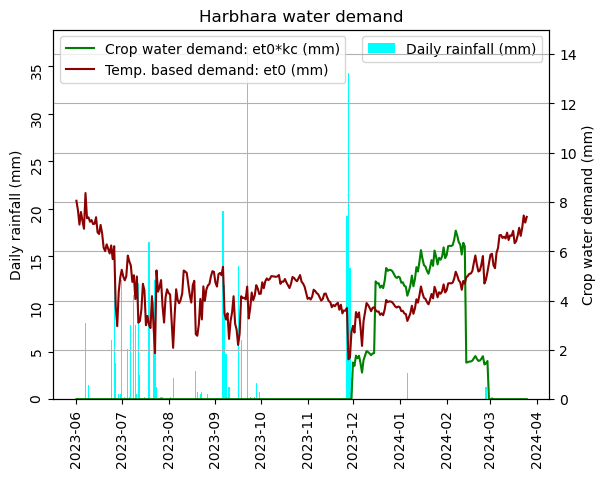

In [4]:
fig, ax1 = plt.subplots()
rain = pd.read_csv('~/rain_low.csv')
et0 = pd.read_csv('~/et0_low.csv')
rain['date'] = pd.to_datetime(rain['date'])
et0['date'] = pd.to_datetime(et0['date'])
og_et0 = copy.deepcopy(et0['et0'])

#plt.plot([item for item in et0['date']], [item for item in et0['et0']])
# harbhara

kc_init = 0.5
kc_mid = 1.15**2
kc_end = 0.3
sowing_dt = datetime(2023, 12, 1)
for (i,dt) in enumerate(et0['date']):
    if dt >= sowing_dt and dt < sowing_dt + timedelta(days=15):
        et0['et0'][i] *= kc_init
    elif dt >= sowing_dt + timedelta(days=15) and dt < sowing_dt + timedelta(days=75):
        et0['et0'][i] *= kc_mid
    elif dt >= sowing_dt + timedelta(days=75) and dt < sowing_dt + timedelta(days=90):
        et0['et0'][i] *= kc_end
    else:
        et0['et0'][i] *= 0

print(np.sum(et0['et0']))

ax1.bar([item for item in rain['date']], [item for item in rain['daily_rain']], color='cyan', label='Daily rainfall (mm)')
ax1.set_ylabel('Daily rainfall (mm)')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax2 = ax1.twinx()
ax2.plot([item for item in et0['date']], [item for item in et0['et0']], color='green', label='Crop water demand: et0*kc (mm)')
ax2.plot([item for item in et0['date']], [item for item in og_et0], color='darkred', label='Temp. based demand: et0 (mm)')
ax2.set_ylabel('Crop water demand (mm)')

ax1.tick_params(rotation=90)
plt.ylim(0,15)
plt.grid()
ax1.legend()
ax2.legend(loc='upper left')
plt.title('Harbhara water demand')
plt.show()

/tmp/ipykernel_6602/2630797939.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et0['et0'][i] *= 0
/tmp/ipykernel_6602/2630797939.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et0['et0'][i] *= 0
/tmp/ipykernel_6602/2630797939.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et0['et0'][i] *= 0
/tmp/ipykernel_6602/2630797939.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



748.1668627499998


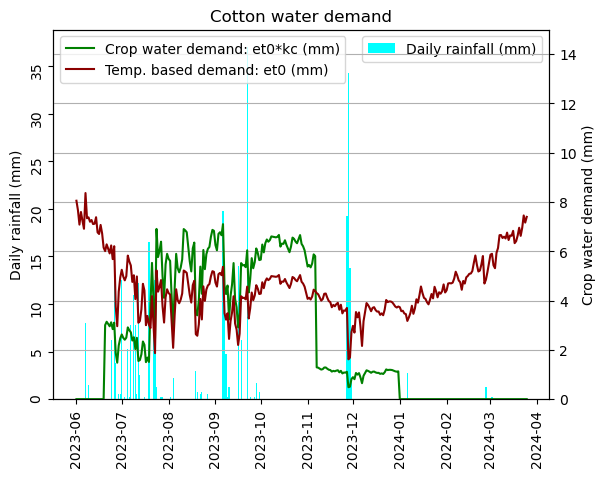

In [5]:
fig, ax1 = plt.subplots()
rain = pd.read_csv('~/rain_low.csv')
et0 = pd.read_csv('~/et0_low.csv')
rain['date'] = pd.to_datetime(rain['date'])
et0['date'] = pd.to_datetime(et0['date'])
og_et0 = copy.deepcopy(et0['et0'])

#plt.plot([item for item in et0['date']], [item for item in et0['et0']])
# cotton

kc_init = 0.5
kc_mid = 1.15**2
kc_end = 0.3
sowing_dt = datetime(2023, 6, 20)
for (i,dt) in enumerate(et0['date']):
    if dt >= sowing_dt and dt < sowing_dt + timedelta(days=30):
        et0['et0'][i] *= kc_init
    elif dt >= sowing_dt + timedelta(days=30) and dt < sowing_dt + timedelta(days=140):
        et0['et0'][i] *= kc_mid
    elif dt >= sowing_dt + timedelta(days=140) and dt < sowing_dt + timedelta(days=195):
        et0['et0'][i] *= kc_end
    else:
        et0['et0'][i] *= 0

print(np.sum(et0['et0']))


ax1.bar([item for item in rain['date']], [item for item in rain['daily_rain']], color='cyan', label='Daily rainfall (mm)')
ax1.set_ylabel('Daily rainfall (mm)')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax2 = ax1.twinx()
ax2.plot([item for item in et0['date']], [item for item in et0['et0']], color='green', label='Crop water demand: et0*kc (mm)')
ax2.plot([item for item in et0['date']], [item for item in og_et0], color='darkred', label='Temp. based demand: et0 (mm)')
ax2.set_ylabel('Crop water demand (mm)')

ax1.tick_params(rotation=90)
plt.ylim(0,15)
plt.grid()
ax1.legend()
ax2.legend(loc='upper left')
plt.title('Cotton water demand')
plt.show()

In [6]:
sql_query = f"""
with farmplots_and_points as (
    select
        f.crop_cycle_22_23,
        f.key,
        st_area(f.farm_geom)/10000 as area_ha,
        p.hru
    from
        nearest_farmplots_map as f
    cross join lateral (
        select
            p.geom,
            p.hru
        from
            amravati_points_with_weather_st as p
        order by
            f.farm_geom <-> p.geom
        limit
            1
    ) as p
)
select
    f.crop_cycle_22_23,
    f.key,
    e.date,
    e.et0,
    f.area_ha
from
    farmplots_and_points as f
join
    amravati_daily_et0_2023 as e
on
    f.hru = e.hru::int
"""
with pgconn.cursor() as curs:
    curs.execute(sql_query)
    rows = curs.fetchall()

farm_dict = {}

for row in rows:
    crop_cycle = row[0]
    key = row[1]
    date = row[2]
    et0 = row[3]
    area = row[4]
    if farm_dict.get(key) is None:
        farm_dict[key] = {
            "date": [],
            "et0": [],
            "area": 0,
            "crop_cycle": None,
            "water_budget": 0
        }
    farm_dict[key]['date'].append(date)
    farm_dict[key]['et0'].append(et0)
    farm_dict[key]['area'] = area
    farm_dict[key]['crop_cycle'] = crop_cycle

sk_area = 0
lk_area = 0
kr_area = 0

for key in farm_dict.keys():
    dt_format = "%Y-%m-%d"
    zipped = zip([datetime.strptime(item, dt_format) for item in farm_dict[key]['date']], [float(item) for item in farm_dict[key]['et0']])
    zipped = sorted(zipped, key = lambda x : x[0])
    farm_dict[key]['date'] = [item[0] for item in zipped]
    farm_dict[key]['et0'] = [item[1] for item in zipped]
    
    if farm_dict[key]['crop_cycle'] == 'short_kharif':
        sk_area += farm_dict[key]['area']
        # soybean
        kc_init = 0.4
        kc_mid = 1.15
        kc_end = 0.5
        sowing_dt = datetime(2023, 6, 20)
        for (i,dt) in enumerate(farm_dict[key]['date']):
            if dt >= sowing_dt and dt < sowing_dt + timedelta(days=15):
                farm_dict[key]['et0'][i] *= kc_init
            elif dt >= sowing_dt + timedelta(days=15) and dt < sowing_dt + timedelta(days=70):
                farm_dict[key]['et0'][i] *= kc_mid
            elif dt >= sowing_dt + timedelta(days=70) and dt < sowing_dt + timedelta(days=85):
                farm_dict[key]['et0'][i] *= kc_end
            else:
                farm_dict[key]['et0'][i] *= 0

    if farm_dict[key]['crop_cycle'] == 'kharif_and_rabi':
        kr_area += farm_dict[key]['area']
        # soybean
        kc_init = 0.4
        kc_mid = 1.15
        kc_end = 0.5
        sowing_dt_kharif = datetime(2023, 6, 20)
            
        # broadbean
        kc_init = 0.5
        kc_mid = 1.15**2
        kc_end = 0.3
        sowing_dt_rabi = datetime(2023, 12, 1)

        for (i,dt) in enumerate(farm_dict[key]['date']):
            if dt >= sowing_dt_kharif and dt < sowing_dt_kharif + timedelta(days=15):
                farm_dict[key]['et0'][i] *= kc_init
            elif dt >= sowing_dt_kharif + timedelta(days=15) and dt < sowing_dt_kharif + timedelta(days=70):
                farm_dict[key]['et0'][i] *= kc_mid
            elif dt >= sowing_dt_kharif + timedelta(days=70) and dt < sowing_dt_kharif + timedelta(days=85):
                farm_dict[key]['et0'][i] *= kc_end
            elif dt >= sowing_dt_rabi and dt < sowing_dt_rabi + timedelta(days=15):
                farm_dict[key]['et0'][i] *= kc_init
            elif dt >= sowing_dt_rabi + timedelta(days=15) and dt < sowing_dt_rabi + timedelta(days=75):
                farm_dict[key]['et0'][i] *= kc_mid
            elif dt >= sowing_dt_rabi + timedelta(days=75) and dt < sowing_dt_rabi + timedelta(days=90):
                farm_dict[key]['et0'][i] *= kc_end
            else:
                farm_dict[key]['et0'][i] *= 0
    
    if farm_dict[key]['crop_cycle'] == 'long_kharif':
        lk_area += farm_dict[key]['area']
        # cotton
        kc_init = 0.35
        kc_mid = 1.2
        kc_end = 0.6
        sowing_dt = datetime(2023, 6, 20)
        for (i,dt) in enumerate(farm_dict[key]['date']):
            if dt >= sowing_dt and dt < sowing_dt + timedelta(days=30):
                farm_dict[key]['et0'][i] *= kc_init
            elif dt >= sowing_dt + timedelta(days=30) and dt < sowing_dt + timedelta(days=140):
                farm_dict[key]['et0'][i] *= kc_mid
            elif dt >= sowing_dt + timedelta(days=140) and dt < sowing_dt + timedelta(days=195):
                farm_dict[key]['et0'][i] *= kc_end
            else:
                farm_dict[key]['et0'][i] *= 0
        
        

total_water_budget = 0
total_area = 0
for key in farm_dict.keys():
    farm_dict[key]['water_budget'] = np.sum(farm_dict[key]['et0'])
    area = farm_dict[key]['area']
    total_water_budget += farm_dict[key]['water_budget']*area
    total_area += area

print(total_water_budget*10000/1000, "metric tonnes of water required to irrigate these farmplots of total area:", total_area)
print("long kharif area (ha):", lk_area)
print("short kharif area (ha):", sk_area)
print("kharif and rabi area (ha):", kr_area)

24211396.571968887 metric tonnes of water required to irrigate these farmplots of total area: 3264.4319876513623
long kharif area (ha): 2138.785471848948
short kharif area (ha): 102.09078559975318
kharif and rabi area (ha): 1023.5557302026596
